Vamos a importar el archivo listings.csv para comenzar a trabajar en el ejercicio 3.

In [51]:
from google.colab import files
import io
import pandas as pd

df = pd.read_csv('listings.csv')
display(df.head())
df.info()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,36121,https://www.airbnb.com/rooms/36121,20250301213336,2025-03-03,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,https://a0.muscache.com/pictures/8776354/35b32...,62165,...,5.00,5.00,5.00,NaN,f,1,0,1,0,0.05
1,36647,https://www.airbnb.com/rooms/36647,20250301213336,2025-03-03,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",https://a0.muscache.com/pictures/miso/Hosting-...,157798,...,4.90,4.38,4.71,NaN,f,1,0,1,0,0.58
2,38663,https://www.airbnb.com/rooms/38663,20250301213336,2025-03-02,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",https://a0.muscache.com/pictures/miso/Hosting-...,165789,...,4.88,4.86,4.62,OSE-STRREG-0001784,f,1,0,1,0,0.28
3,38833,https://www.airbnb.com/rooms/38833,20250301213336,2025-03-03,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,https://a0.muscache.com/pictures/7554f9e5-4ab0...,166532,...,4.96,4.79,4.82,OSE-STRREG-0000476,f,1,1,0,0,1.36
4,39282,https://www.airbnb.com/rooms/39282,20250301213336,2025-03-02,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,https://a0.muscache.com/pictures/ef8f43ad-d967...,168525,...,4.88,4.85,4.78,OSE-STRREG-0001150,f,2,0,2,0,1.54


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37434 entries, 0 to 37433
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            37434 non-null  int64  
 1   listing_url                                   37434 non-null  object 
 2   scrape_id                                     37434 non-null  int64  
 3   last_scraped                                  37434 non-null  object 
 4   source                                        37434 non-null  object 
 5   name                                          37432 non-null  object 
 6   description                                   36441 non-null  object 
 7   neighborhood_overview                         20224 non-null  object 
 8   picture_url                                   37433 non-null  object 
 9   host_id                                       37434 non-null 

Vamos a aplicar un preprocesamiento el cual incluye limpieza, transformación e ingeniería de features.

In [52]:
# Limpieza y transformación de price

# 1) Eliminar símbolos y comas
df['price'] = (
  df['price']
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)

# Quitar filas sin price
df = df.dropna(subset=['price'])

# Eliminar outliers de price
p1 = df['price'].quantile(0.01)
p99 = df['price'].quantile(0.99)
df = df[(df['price'] >= p1) & (df['price'] <= p99)]

# 2) Revisar resultado
df['price'].head()

# Tratamiento de valores faltantes
nulos = df.isnull().sum().sort_values(ascending=False)
display(nulos.head(20))

# Usamos log1p para estabilizar la varianza
df['log_price'] = np.log1p(df['price'])

# Ingeniería de features

# 1) Años de experiencia del anfitrión

df['host_since'] = pd.to_datetime(df['host_since'])
df['host_experience_years'] = (
  (pd.Timestamp.today() - df['host_since']).dt.days / 365
)

# 2) Longitud de la descripción

df['description_length'] = df['description'].fillna('').str.len()
df['log_bedrooms'] = np.log1p(df['bedrooms'])
df['log_bathrooms'] = np.log1p(df['bathrooms'])
df['log_beds'] = np.log1p(df['beds'])

# 3) Cantidad de amenities

df['amenities'] = df['amenities'].astype(str)
df['num_amenities'] = df['amenities'].str.count(',') + 1


for amen in ['Wifi', 'Air conditioning', 'Kitchen', 'Heating']:
    df[f'has_{amen.lower().replace(" ","_")}'] = df['amenities'].str.contains(amen).astype(int)


,0
calendar_updated,21891
license,17510
neighborhood_overview,9826
neighbourhood,9826
host_about,8696
review_scores_location,6562
review_scores_checkin,6561
first_review,6561
reviews_per_month,6561
review_scores_cleanliness,6561


Armamos los conjuntos de train y de test

In [53]:
df = df.dropna(subset=['price'])


numeric_feats = [
  'host_experience_years',
  'description_length',
  'num_amenities',
  'bathrooms',
  'bedrooms',
  'beds'
]
categorical_feats = [
  'neighbourhood_group_cleansed',
  'room_type'
]

X = df[numeric_feats + categorical_feats]
y = df['log_price']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.2,
  random_state=42
)


Creamos el pipeline de preprocesamiento, con el objetivo de garantizar consistencia ante cada fold de nuestros modelos.

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import RidgeCV

# Numéricos: mediana + StandardScaler
numeric_transformer = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('poly',    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

# Categóricos: constante + OneHot
categorical_transformer = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
  ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
  ('num', numeric_transformer,     numeric_feats),
  ('cat', categorical_transformer, categorical_feats)
])

alphas = np.logspace(-3, 3, 7)
pipe_ridge = Pipeline([
    ('pre',  preprocessor),
    ('model', RidgeCV(alphas=alphas, cv=8))
])

y_train_orig = np.expm1(y_train)
# Le agregamos peso a nuestros conjuntos para obtener luego predicciones más precisas y menos outliers
weights = y_train_orig / y_train_orig.mean()

pipe_ridge.fit(X_train, y_train)
print("Mejor alpha:", pipe_ridge.named_steps['model'].alpha_)

pipe_ridge_weighted = pipe_ridge
pipe_ridge_weighted.fit(
    X_train, y_train,
    model__sample_weight=weights
)

Mejor alpha: 1.0


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['host_experience_years',
                                                   'description_length',
                                                   'num_amenities', 'bathrooms',
                                                   'bedrooms', 'beds']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['neighbourhood_group_cleansed',
                                                   'room_type'])])),
                ('model',
                 RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         cv=8))])

Aplicamos el entrenamiento utilizando Regresión Lineal a nuestros conjuntos x e y de train y test, calculando las métricas resultantes de dicho entrenamiento.

In [55]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def eval_exp(model, X, y_true):
    y_pred_log = model.predict(X)
    y_pred = np.expm1(y_pred_log)  # deshacer log1p para trabajar con una escala que refleje mejor los valores reales
    y_true_u = np.expm1(y_true)
    return {
        'R2':   r2_score(y_true_u, y_pred),
        'MAE':  mean_absolute_error(y_true_u, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true_u, y_pred))
    }

print("Train:", eval_exp(pipe_ridge, X_train, y_train))
print("Test: ", eval_exp(pipe_ridge, X_test,  y_test))


Train: {'R2': 0.3039053923140075, 'MAE': 94.3194321190188, 'RMSE': np.float64(132.8126504563586)}
Test:  {'R2': 0.28502216533096614, 'MAE': 96.1995000537673, 'RMSE': np.float64(137.45196096355522)}


Analizamos la gráfica entre precio real y el precio predicho. Los valores cercanos a la línea punteada a 45º indican un mayor nivel de precisión en la predicción.

Log predicho: min = 4.148147322028329  max = 7.262151701131413


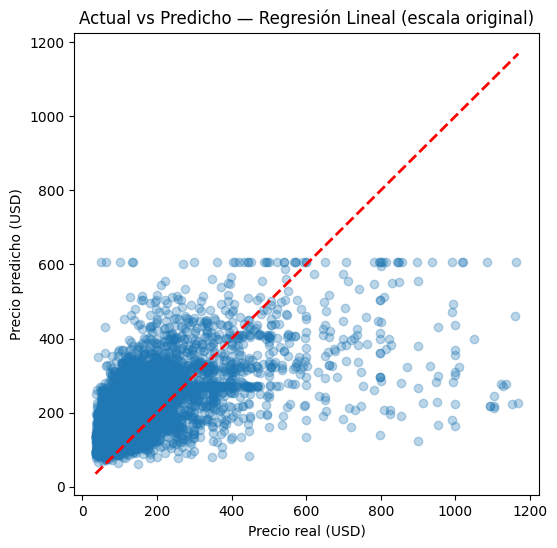

In [56]:
import matplotlib.pyplot as plt

y_pred_log = pipe_ridge.predict(X_test)

umbral = np.percentile(y_pred_log, 99)
y_pred_log_clipped = np.clip(y_pred_log, None, umbral)

print("Log predicho: min =", y_pred_log.min(), " max =", y_pred_log.max())

# Volver a precio original
y_test_orig   = np.expm1(y_test)       # deshace log1p sobre el target real
y_pred_orig   = np.expm1(y_pred_log_clipped)   # deshace log1p sobre la predicción

# Gráfico
plt.figure(figsize=(6,6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.3)
plt.plot(
    [y_test_orig.min(), y_test_orig.max()],
    [y_test_orig.min(), y_test_orig.max()],
    'r--', lw=2
)
plt.xlabel('Precio real (USD)')
plt.ylabel('Precio predicho (USD)')
plt.title('Actual vs Predicho — Regresión Lineal (escala original)')
plt.show()


Analizamos las features más importantes de nuestro Dataset inicial y su impacto o injerencia frente a los entrenamientos y las predicciones de precios.

,feature,coef,abs_coef
12,cat__room_type_Hotel room,141.166985,141.166985
8,cat__neighbourhood_group_cleansed_Manhattan,110.422408,110.422408
13,cat__room_type_Private room,-80.472142,80.472142
3,num__bathrooms,61.895829,61.895829
14,cat__room_type_Shared room,-51.205716,51.205716
10,cat__neighbourhood_group_cleansed_Staten Island,-48.465831,48.465831
9,cat__neighbourhood_group_cleansed_Queens,-29.936200,29.936200
5,num__beds,28.718216,28.718216
6,cat__neighbourhood_group_cleansed_Bronx,-25.624714,25.624714
4,num__bedrooms,23.322352,23.322352


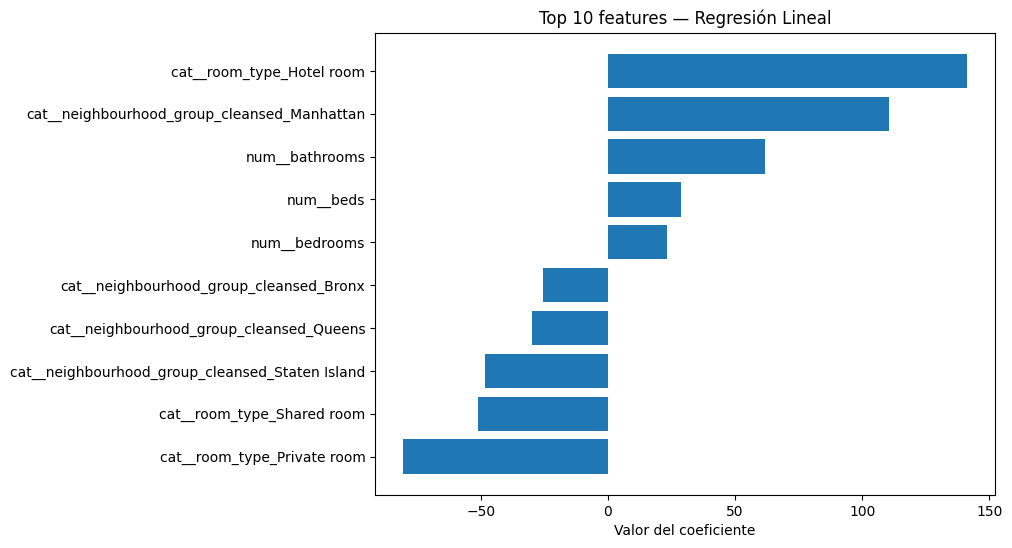

In [57]:
import numpy as np

# Nombres de feature tras el preprocesador
feature_names = pipe_lr.named_steps['pre'] \
                       .get_feature_names_out()

coefs = pipe_lr.named_steps['model'].coef_
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef':    coefs
}).assign(abs_coef=lambda d: d['coef'].abs()) \
 .sort_values('abs_coef', ascending=False)

# Mostrar las top 10
display(coef_df.head(10))

plt.figure(figsize=(8,6))
top10 = coef_df.head(10).sort_values('coef', ascending=True)
plt.barh(top10['feature'], top10['coef'])

# Gráfico
plt.xlabel('Valor del coeficiente')
plt.title('Top 10 features — Regresión Lineal')
plt.show()


Aplicamos el entrenamiento utilizando XGBoost con Cross-Validation a nuestros conjuntos x e y de train y test, calculando las métricas resultantes de dicho entrenamiento.

In [62]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Definimos el pipeline
pipe_xgb = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    ))
])

# Espacio de búsqueda para RandomizedSearch
param_dist = {
    'model__n_estimators':    [100, 200, 300],
    'model__max_depth':       [3, 5, 7],
    'model__learning_rate':   [0.01, 0.05, 0.1],
    'model__subsample':       [0.6, 0.8, 1.0],
    'model__colsample_bytree':[0.6, 0.8, 1.0],
    'model__reg_alpha':       [0, 0.1, 1],
    'model__reg_lambda':      [1, 5, 10]
}

# RandomizedSearchCV (30 iteraciones, 5-fold CV)
rs_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist,
    n_iter=40,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 4) Ejecutar la búsqueda de hiperparámetros
rs_xgb.fit(X_train, y_train)

# 5) Obtener el mejor estimador y sus parámetros
best_xgb = rs_xgb.best_estimator_
print("Mejores parámetros:", rs_xgb.best_params_)

# Función para evaluar en escala real (deshaciendo el log1p)
def eval_model_log_with_mse(model, X, y_log, label):
    y_pred_log = model.predict(X)
    y_true = np.expm1(y_log)
    y_pred = np.expm1(y_pred_log)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {
        'set':  label,
        'MSE':  mse,
        'RMSE': rmse,
        'MAE':  mae,
        'R2':   r2
    }

# Calculamos métricas en Train y Test
res_train_xgb = eval_model_log_with_mse(best_xgb, X_train, y_train, 'Train')
res_test_xgb  = eval_model_log_with_mse(best_xgb, X_test,  y_test,  'Test')

metrics_xgb_df = pd.DataFrame([res_train_xgb, res_test_xgb]).set_index('set')
display(metrics_xgb_df)


Fitting 10 folds for each of 40 candidates, totalling 400 fits
Mejores parámetros: {'model__subsample': 0.8, 'model__reg_lambda': 1, 'model__reg_alpha': 0.1, 'model__n_estimators': 300, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}


,MSE,RMSE,MAE,R2
set,,,,
Train,3988.244851,63.152552,33.927212,0.842612
Test,11852.581612,108.869562,59.606815,0.551457
